In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from io import BytesIO

In [4]:
## retrieves historical price data for a list of tickers using the Yahoo Finance API (yfinance). It fetches adjusted closing prices from the specified date range.
def get_data(tickers, start="2005-01-01", end="2023-01-01"):
    return yf.download(tickers, start=start, end=end)['Adj Close']

# VaR Calculations

1. Historical VaR

2. Parametric VaR

3. MC-VaR

In [5]:
# Historical VaR
def calculate_historical_var(returns, weights, confidence_level, time_horizon=10):
    portfolio_returns = returns.dot(weights)  # Portfolio returns based on weights
    return np.percentile(portfolio_returns, 100 - confidence_level) * np.sqrt(time_horizon)

## This method uses historical data (past returns) to estimate the worst-case loss over a given time horizon, assuming history repeats itself.
# Calculate the daily returns of the assets in the portfolio.
# Multiply the returns by the portfolio weights to calculate the portfolio's daily returns.
# Use the historical returns to find the return at the desired confidence level (e.g., 95th percentile). This represents the maximum expected loss over the time period, with a 95% confidence level.
# Scale the result by the time horizon to get the overall VaR

In [6]:
# Parametric VaR
def calculate_parametric_var(returns, weights, confidence_level, time_horizon=10):
    portfolio_returns = returns.dot(weights)
    mu, sigma = portfolio_returns.mean(), portfolio_returns.std()
    return stats.norm.ppf(1 - confidence_level/100) * sigma * np.sqrt(time_horizon) - mu * time_horizon

## This method assumes that returns follow a normal distribution and uses the mean (average) and standard deviation (volatility) of portfolio returns to calculate the VaR.
# Calculate the mean (mu) and standard deviation (sigma) of the portfolio's returns.
# Use the inverse of the cumulative normal distribution (stats.norm.ppf()) to find the z-score that corresponds to the confidence level.
# Multiply the z-score by the portfolio's standard deviation and scale by the time horizon
# This method relies on statistical properties, assuming that future returns are normally distributed.

In [7]:
# Monte Carlo simulation VaR
def calculate_monte_carlo_var(returns, weights, confidence_level, time_horizon=10, simulations=10000):
    mu, cov_matrix = returns.mean().values, returns.cov().values
    correlated_returns = np.random.multivariate_normal(mu, cov_matrix, simulations)
    portfolio_returns = np.dot(correlated_returns, weights)
    return np.percentile(portfolio_returns, 100 - confidence_level) * np.sqrt(time_horizon)

## This method simulates thousands of possible future returns using the portfolio's historical mean and covariance (relationship between assets). It then estimates VaR based on these simulated returns.
# Use the historical mean and covariance matrix to generate random possible future returns for the portfolio.
# Multiply these simulated returns by the portfolio weights to calculate simulated portfolio returns.
# Find the VaR by selecting the return at the desired percentile from the simulated portfolio returns.

# Stress Testing

Stress testing is used to assess how a portfolio performs under hypothetical adverse scenarios. The goal is to measure the portfolio's sensitivity to extreme changes in market conditions.


*returns*: This is a DataFrame where each column represents the returns of an asset in the portfolio, and each row represents returns for a specific period (e.g., daily returns).

*weights*: This is a vector that represents the proportion of the portfolio allocated to each asset. For instance, if a portfolio is 50% in stocks and 50% in bonds, the weights vector might be [0.5, 0.5].

*scenario*: This is a hypothetical scenario where each asset experiences a specific return or loss. For instance, you could define a scenario where all tech stocks drop by 10%, or all bonds lose 5%.

**stressed_returns = returns + pd.Series(scenario, index=returns.columns)**: The hypothetical stress scenario is added to the historical returns of each asset. This simulates how the portfolio would perform under the defined adverse market conditions.

**stressed_returns.dot(weights).iloc[-1]**: This line calculates the total portfolio return by multiplying the stressed returns with the portfolio weights (via matrix multiplication). It returns the stressed portfolio return on the last date (denoted by iloc[-1]), giving the impact of the stress scenario on the entire portfolio.

In [8]:
# Stress testing the portfolio for different hypothetical scenarios
def stress_test(returns, weights, scenario):
    stressed_returns = returns + pd.Series(scenario, index=returns.columns)
    return stressed_returns.dot(weights).iloc[-1]

# Backtesting

Backtesting VaR is used to check whether a risk model accurately predicts the number of violations (or times the actual loss exceeded the predicted VaR) based on historical data.

*returns*: This is a DataFrame containing the historical returns for each asset in the portfolio.

*weights*: This is the vector of portfolio allocations, representing the proportion invested in each asset.

*var*: This is the Value at Risk (VaR) amount, which represents the maximum loss the portfolio might experience with a certain level of confidence (e.g., 95% confidence) over a specific period (e.g., daily VaR).

*confidence_level*: This is the confidence level (e.g., 95% or 99%) used to calculate the VaR. For example, at a 95% confidence level, the VaR predicts that the portfolio will not lose more than the VaR amount on 95% of trading days, but on 5% of the days, the loss might exceed the VaR.

**portfolio_returns = returns.dot(weights)**: This calculates the portfolio's historical returns by multiplying the asset returns by the portfolio weights. The result is the total daily return for the entire portfolio.

**violations = (portfolio_returns < -var).sum()**: This counts the number of days where the portfolio loss exceeded the VaR (i.e., where actual returns were lower than the negative VaR value).

**expected_violations = len(portfolio_returns) * (1 - confidence_level/100)**: This calculates how many violations we expect based on the confidence level. For example, if you have 250 trading days and a 95% confidence level, you expect 5% of those days (i.e., 12-13 days) to have losses exceeding VaR.

In [9]:
# Backtesting VaR to check the number of violations in reality
def backtest_var(returns, weights, var, confidence_level):
    portfolio_returns = returns.dot(weights)
    violations = (portfolio_returns < -var).sum()  # Count when losses exceed VaR
    expected_violations = len(portfolio_returns) * (1 - confidence_level/100)
    return violations, expected_violations

In [ ]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'BND', 'GLD', 'XOM', 'JPM']
weights = [0.15, 0.15, 0.15, 0.15, 0.1, 0.1, 0.1, 0.1]
confidence_level = 95
risk_appetite = -0.05
data_start = "2005-01-01"
data_end = "2023-01-01"

# Fetch data and calculate returns
data = get_data(tickers, start=data_start, end=data_end)
returns = data.pct_change().dropna()


[*********************100%***********************]  8 of 8 completed


In [ ]:
data

Ticker,AAPL,AMZN,BND,GLD,GOOGL,JPM,MSFT,XOM
Date,,,,,,,,
2005-01-03 00:00:00+00:00,0.954408,2.226000,NaN,43.020000,5.060293,22.842474,18.593433,26.000973
2005-01-04 00:00:00+00:00,0.964210,2.107000,NaN,42.740002,4.855344,22.607042,18.662966,25.824488
2005-01-05 00:00:00+00:00,0.972655,2.088500,NaN,42.669998,4.830632,22.654139,18.621246,25.689528
2005-01-06 00:00:00+00:00,0.973409,2.052500,NaN,42.150002,4.706813,22.783611,18.600388,26.016548
2005-01-07 00:00:00+00:00,1.044284,2.116000,NaN,41.840000,4.839118,22.601156,18.544760,25.845261
...,...,...,...,...,...,...,...,...
2022-12-23 00:00:00+00:00,130.631363,85.250000,68.418442,167.259995,89.009598,124.506882,235.345566,102.460434
2022-12-27 00:00:00+00:00,128.818405,83.040001,67.890190,168.669998,87.174141,124.943146,233.600662,103.884010
2022-12-28 00:00:00+00:00,124.865585,81.820000,67.795837,167.910004,85.807526,125.626022,231.205093,102.177589


[*********************100%***********************]  8 of 8 completed


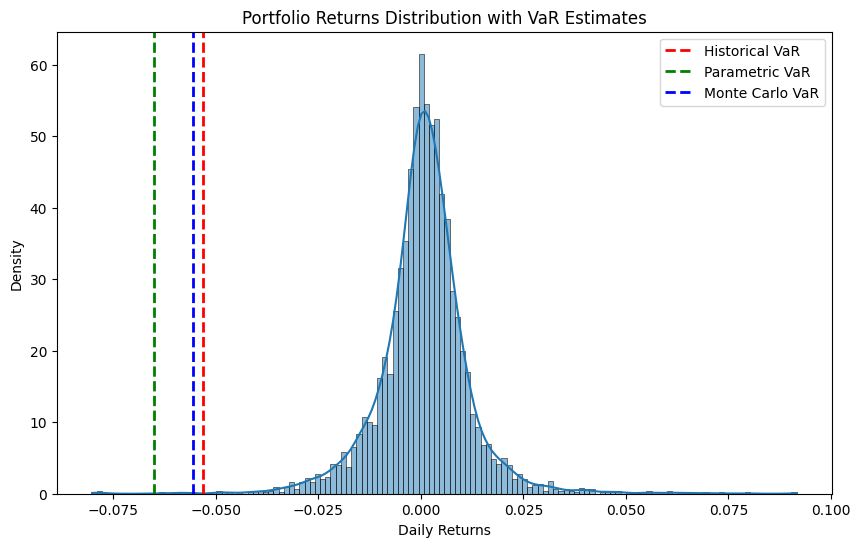


Portfolio Composition:
AAPL: 15.00%
MSFT: 15.00%
GOOGL: 15.00%
AMZN: 15.00%
BND: 10.00%
GLD: 10.00%
XOM: 10.00%
JPM: 10.00%

Data used from 2005-01-01 to 2023-01-01

Value at Risk (VaR) Results:
Historical VaR: -5.31%
Parametric VaR: -6.51%
Monte Carlo VaR: -5.56%

Stress Test Results:
Market Crash: -9.89%
Tech Selloff: -10.39%
Energy Crisis: -0.89%
Financial Crisis: -7.39%

Risk Appetite: -5.00%
Historical VaR is within the risk appetite.
Parametric VaR is within the risk appetite.
Monte Carlo VaR is within the risk appetite.

Backtesting Results:
Number of VaR violations: 3950
Expected number of violations: 198.05
Conclusion: VaR model may be underestimating risk


In [12]:
# Main function to run the analysis and print the results
def main():
    # Portfolio data
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'BND', 'GLD', 'XOM', 'JPM']
    weights = [0.15, 0.15, 0.15, 0.15, 0.1, 0.1, 0.1, 0.1]
    confidence_level = 95
    risk_appetite = -0.05
    data_start = "2005-01-01"
    data_end = "2023-01-01"

    # Fetch data and calculate returns
    data = get_data(tickers, start=data_start, end=data_end)
    returns = data.pct_change().dropna()

    # Calculate VaR using different methods
    historical_var = calculate_historical_var(returns, weights, confidence_level)
    parametric_var = calculate_parametric_var(returns, weights, confidence_level)
    monte_carlo_var = calculate_monte_carlo_var(returns, weights, confidence_level)

    var_results = {
        'Historical VaR': historical_var,
        'Parametric VaR': parametric_var,
        'Monte Carlo VaR': monte_carlo_var
    }

    # Stress test scenarios
    scenarios = {
        "Market Crash": [-0.1] * len(tickers),
        "Tech Selloff": [-0.15, -0.15, -0.15, -0.15, -0.05, 0, -0.05, -0.05],
        "Energy Crisis": [-0.05, -0.05, -0.05, -0.05, 0, 0.1, 0.15, -0.05],
        "Financial Crisis": [-0.1, -0.1, -0.1, -0.1, 0.05, 0.05, -0.05, -0.2]
    }

    stressed_returns = {name: stress_test(returns, weights, scenario) for name, scenario in scenarios.items()}

    # Backtesting
    historical_violations, expected_violations = backtest_var(returns, weights, historical_var, confidence_level)

    if historical_violations <= expected_violations * 1.2 and historical_violations >= expected_violations * 0.8:
        backtest_conclusion = "VaR model performs adequately"
    elif historical_violations > expected_violations * 1.2:
        backtest_conclusion = "VaR model may be underestimating risk"
    else:
        backtest_conclusion = "VaR model may be overestimating risk"

    backtest_results = {
        'violations': historical_violations,
        'expected': expected_violations,
        'conclusion': backtest_conclusion
    }

    # Plot the distribution of portfolio returns with VaR estimates
    plt.figure(figsize=(10, 6))
    portfolio_returns = returns.dot(weights)
    sns.histplot(portfolio_returns, kde=True, stat="density")
    plt.axvline(historical_var, color='r', linestyle='dashed', linewidth=2, label='Historical VaR')
    plt.axvline(parametric_var, color='g', linestyle='dashed', linewidth=2, label='Parametric VaR')
    plt.axvline(monte_carlo_var, color='b', linestyle='dashed', linewidth=2, label='Monte Carlo VaR')
    plt.title("Portfolio Returns Distribution with VaR Estimates")
    plt.xlabel("Daily Returns")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    # Print the results
    print("\nPortfolio Composition:")
    for ticker, weight in zip(tickers, weights):
        print(f"{ticker}: {weight:.2%}")

    print(f"\nData used from {data_start} to {data_end}")

    print("\nValue at Risk (VaR) Results:")
    for method, var in var_results.items():
        print(f"{method}: {var:.2%}")

    print("\nStress Test Results:")
    for scenario, stressed_return in stressed_returns.items():
        print(f"{scenario}: {stressed_return:.2%}")

    print(f"\nRisk Appetite: {risk_appetite:.2%}")
    for method, var in var_results.items():
        print(f"{method} {'is within' if var < risk_appetite else 'exceeds'} the risk appetite.")

    print(f"\nBacktesting Results:")
    print(f"Number of VaR violations: {backtest_results['violations']}")
    print(f"Expected number of violations: {backtest_results['expected']:.2f}")
    print(f"Conclusion: {backtest_results['conclusion']}")

if __name__ == "__main__":
    main()


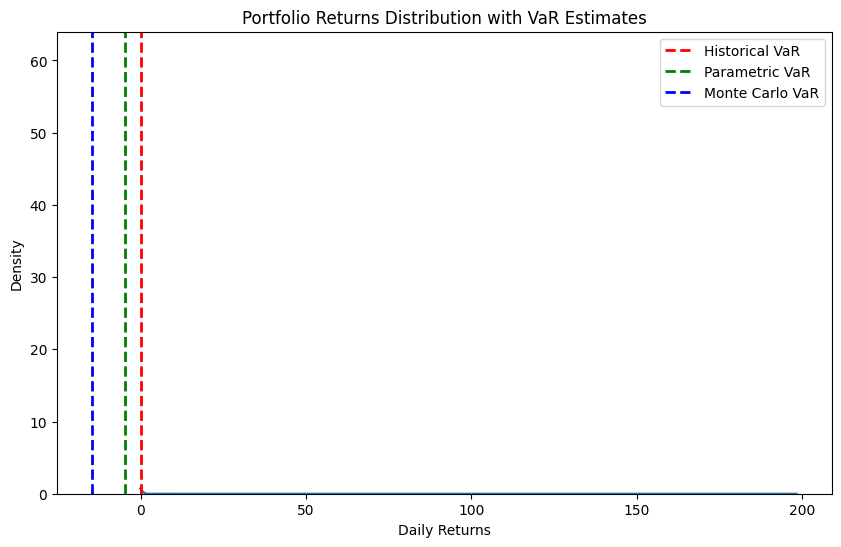


Portfolio Composition:
HDFCBANK: 15.00%
HINDUNILVR: 15.00%
RELIANCE: 20.00%
SUNPHARMA: 10.00%
TATAMOTORS: 10.00%
TCS: 15.00%
FUTCOM-OIL: 15.00%

Value at Risk (VaR) Results:
Historical VaR: -1.73%
Parametric VaR: -469.58%
Monte Carlo VaR: -1467.62%

Stress Test Results:
Market Crash: -8.81%
Tech Selloff: -5.81%
Energy Crisis: 1.94%
Financial Crisis: -7.06%

Risk Appetite: -5.00%
Historical VaR exceeds the risk appetite.
Parametric VaR is within the risk appetite.
Monte Carlo VaR is within the risk appetite.

Backtesting Results:
Number of VaR violations: 4624
Expected number of violations: 245.85
Conclusion: VaR model may be underestimating risk


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Define the get_data function to read the CSV file
def get_data(file_path):
    # Read the CSV data into a DataFrame
    data = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    return data

# Historical VaR
def calculate_historical_var(returns, weights, confidence_level, time_horizon=1):
    portfolio_returns = returns.dot(weights)  # Portfolio returns based on weights
    return np.percentile(portfolio_returns, 100 - confidence_level) * np.sqrt(time_horizon)

# Parametric VaR
def calculate_parametric_var(returns, weights, confidence_level, time_horizon=1):
    portfolio_returns = returns.dot(weights)
    mu, sigma = portfolio_returns.mean(), portfolio_returns.std()
    return stats.norm.ppf(1 - confidence_level/100) * sigma * np.sqrt(time_horizon) - mu * time_horizon

# Monte Carlo simulation VaR
def calculate_monte_carlo_var(returns, weights, confidence_level, time_horizon=10, simulations=10000):
    mu, cov_matrix = returns.mean().values, returns.cov().values
    correlated_returns = np.random.multivariate_normal(mu, cov_matrix, simulations)
    portfolio_returns = np.dot(correlated_returns, weights)
    return np.percentile(portfolio_returns, 100 - confidence_level) * np.sqrt(time_horizon)

# Stress testing the portfolio for different hypothetical scenarios
def stress_test(returns, weights, scenario):
    stressed_returns = returns + pd.Series(scenario, index=returns.columns)
    return stressed_returns.dot(weights).iloc[-1]

# Backtesting VaR to check the number of violations in reality
def backtest_var(returns, weights, var, confidence_level):
    portfolio_returns = returns.dot(weights)
    violations = (portfolio_returns < -var).sum()  # Count when losses exceed VaR
    expected_violations = len(portfolio_returns) * (1 - confidence_level/100)
    return violations, expected_violations

# Main function to run the analysis and print the results
def main():
    # File path for the portfolio CSV
    file_path = 'portfolio.csv'

    # Portfolio weights for the 7 assets
    weights = [0.15, 0.15, 0.2, 0.1, 0.1, 0.15, 0.15]  # Modify as needed
    confidence_level = 95
    risk_appetite = -0.05

    # Fetch data and calculate returns
    data = get_data(file_path)
    returns = data.pct_change().dropna()  # Daily returns

    # Calculate VaR using different methods
    historical_var = calculate_historical_var(returns, weights, confidence_level)
    parametric_var = calculate_parametric_var(returns, weights, confidence_level)
    monte_carlo_var = calculate_monte_carlo_var(returns, weights, confidence_level)

    var_results = {
        'Historical VaR': historical_var,
        'Parametric VaR': parametric_var,
        'Monte Carlo VaR': monte_carlo_var
    }

    # Stress test scenarios (hypothetical)
    scenarios = {
        "Market Crash": [-0.1] * len(weights),
        "Tech Selloff": [-0.15, -0.15, -0.15, -0.05, -0.05, 0, 0.1],
        "Energy Crisis": [-0.05, -0.05, -0.05, -0.05, 0, 0.15, 0.1],
        "Financial Crisis": [-0.1, -0.1, -0.1, 0, 0.05, -0.05, -0.2]
    }

    stressed_returns = {name: stress_test(returns, weights, scenario) for name, scenario in scenarios.items()}

    # Backtesting
    historical_violations, expected_violations = backtest_var(returns, weights, historical_var, confidence_level)

    if historical_violations <= expected_violations * 1.2 and historical_violations >= expected_violations * 0.8:
        backtest_conclusion = "VaR model performs adequately"
    elif historical_violations > expected_violations * 1.2:
        backtest_conclusion = "VaR model may be underestimating risk"
    else:
        backtest_conclusion = "VaR model may be overestimating risk"

    backtest_results = {
        'violations': historical_violations,
        'expected': expected_violations,
        'conclusion': backtest_conclusion
    }

    # Plot the distribution of portfolio returns with VaR estimates
    plt.figure(figsize=(10, 6))
    portfolio_returns = returns.dot(weights)
    sns.histplot(portfolio_returns, kde=True, stat="density")
    plt.axvline(historical_var, color='r', linestyle='dashed', linewidth=2, label='Historical VaR')
    plt.axvline(parametric_var, color='g', linestyle='dashed', linewidth=2, label='Parametric VaR')
    plt.axvline(monte_carlo_var, color='b', linestyle='dashed', linewidth=2, label='Monte Carlo VaR')
    plt.title("Portfolio Returns Distribution with VaR Estimates")
    plt.xlabel("Daily Returns")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    # Print the results
    print("\nPortfolio Composition:")
    for asset, weight in zip(data.columns, weights):
        print(f"{asset}: {weight:.2%}")

    print(f"\nValue at Risk (VaR) Results:")
    for method, var in var_results.items():
        print(f"{method}: {var:.2%}")

    print("\nStress Test Results:")
    for scenario, stressed_return in stressed_returns.items():
        print(f"{scenario}: {stressed_return:.2%}")

    print(f"\nRisk Appetite: {risk_appetite:.2%}")
    for method, var in var_results.items():
        print(f"{method} {'is within' if var < risk_appetite else 'exceeds'} the risk appetite.")

    print(f"\nBacktesting Results:")
    print(f"Number of VaR violations: {backtest_results['violations']}")
    print(f"Expected number of violations: {backtest_results['expected']:.2f}")
    print(f"Conclusion: {backtest_results['conclusion']}")

if __name__ == "__main__":
    main()